In [129]:
#Importing Libraries
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten

In [131]:
count = 0
# Ganti 'Images/' dengan rute absolut direktori
base_path = r'C:\Users\yosep\Dataset\Images'

# List semua subdirektori
dirs = os.listdir(base_path)

for dir in dirs:
    # Menggabungkan rute untuk subdirektori
    dir_path = os.path.join(base_path, dir)
    
    # Memastikan hanya direktori yang diproses
    if os.path.isdir(dir_path):
        files = os.listdir(dir_path)
        print(dir + ' Folder has ' + str(len(files)) + ' Images')
        count += len(files)

print('Images Folder has ' + str(count) + ' Images')

kepiting Folder has 315 Images
Lobster Folder has 480 Images
Udang Folder has 228 Images
Images Folder has 1023 Images


In [133]:
base_dir = r'C:\Users\yosep\Dataset\Images'
img_size = 180
batch = 64

In [135]:
train_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'training',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

val_ds = tf.keras.utils.image_dataset_from_directory( base_dir,
                                                       seed = 123,
                                                       validation_split=0.2,
                                                       subset = 'validation',
                                                       batch_size=batch,
                                                       image_size=(img_size,img_size))

Found 1023 files belonging to 3 classes.
Using 819 files for training.
Found 1023 files belonging to 3 classes.
Using 204 files for validation.


In [137]:
animal_names = train_ds.class_names
animal_names

['Lobster', 'Udang', 'kepiting']

In [139]:
import matplotlib.pyplot as plt

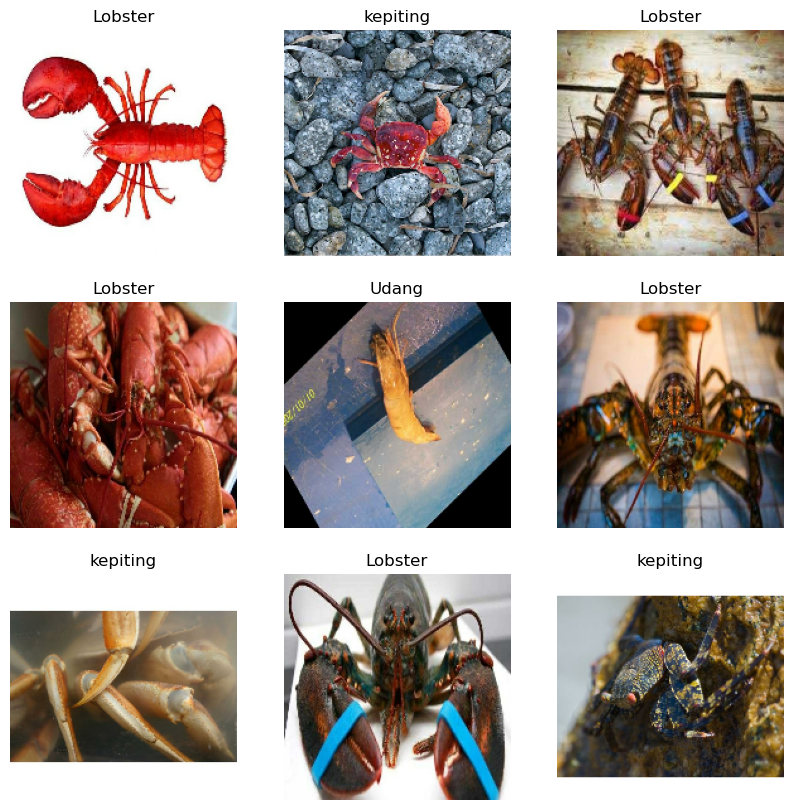

In [141]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(animal_names[labels[i]])
        plt.axis('off')

In [143]:
AUTOTUNE = tf.data.AUTOTUNE

In [145]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

In [147]:
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [149]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

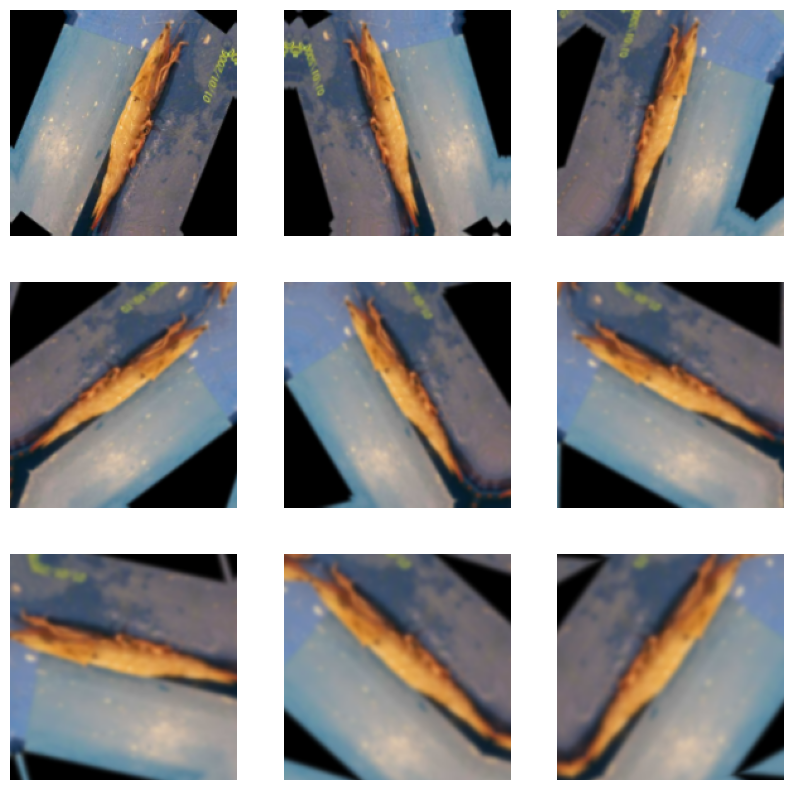

In [153]:
i = 0
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
    for i in range(9):
        images = data_augmentation(images)
        plt.subplot(3,3, i+1)
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

In [155]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    MaxPooling2D(),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

In [157]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False  # Membekukan layer pre-trained

model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


C:\Users\yosep\AppData\Local\Temp\ipykernel_14772\84541115.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(180, 180, 3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 14s 1us/step


In [158]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [161]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.3480 - loss: 1.7800 - val_accuracy: 0.7843 - val_loss: 0.7081 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 883ms/step - accuracy: 0.6024 - loss: 0.8921 - val_accuracy: 0.8627 - val_loss: 0.4927 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 877ms/step - accuracy: 0.7003 - loss: 0.7044 - val_accuracy: 0.8775 - val_loss: 0.4180 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 893ms/step - accuracy: 0.7815 - loss: 0.5552 - val_accuracy: 0.8824 - val_loss: 0.3874 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 876ms/step - accuracy: 0.7594 - loss: 0.5932 - val_accuracy: 0.8873 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 873ms/step - accuracy: 0.8069 - loss: 0.5083 - val_accuracy: 0.8873 - val_loss: 0.3504 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 898ms/step - accuracy: 0.8081 - loss: 0.464

In [163]:
def classify_images(image_path):
    input_image = tf.keras.utils.load_img(image_path, target_size=(180,180))
    input_image_array = tf.keras.utils.img_to_array(input_image)
    input_image_exp_dim = tf.expand_dims(input_image_array,0)

    predictions = model.predict(input_image_exp_dim)
    result = tf.nn.softmax(predictions[0])
    outcome = 'The Image belongs to ' + animal_names[np.argmax(result)] + ' with a score of '+ str(np.max(result)*100)
    return outcome  

In [165]:
classify_images('sample/asu_kayang.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


'The Image belongs to Lobster with a score of 36.60203814506531'

In [167]:
model.save('animal_Recog_Model.h5')

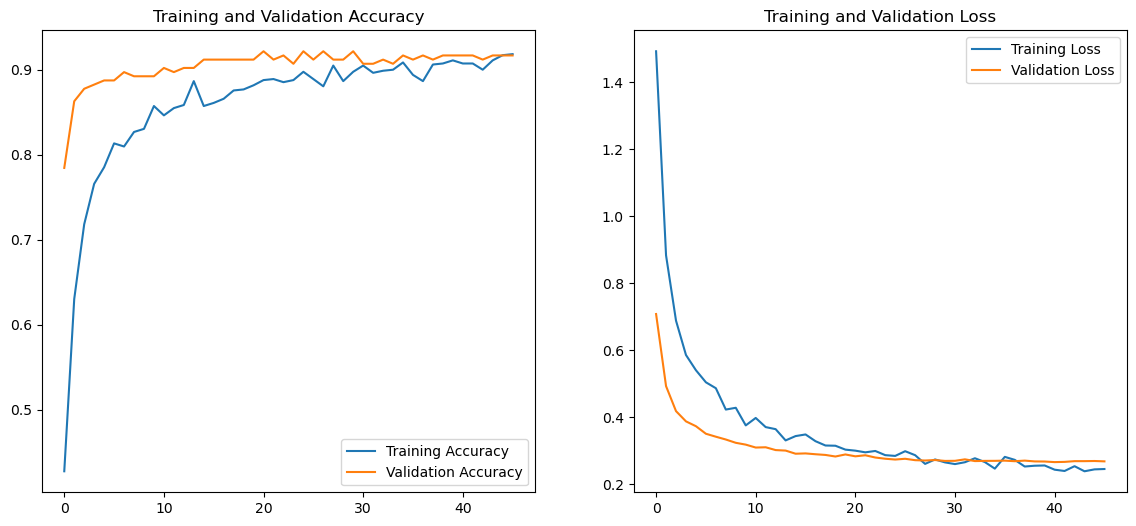

In [169]:
# Ekstrak data dari history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Membuat grafik akurasi dan loss
plt.figure(figsize=(14, 6))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()
